In [1]:
import pandas
import tensorflow

print(pandas.__version__)
print(tensorflow.__version__)

1.3.3
2.6.0


In [2]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose/data/') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


In [4]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [8]:
User_length = data.groupby('UserId').size()
User_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [9]:
User_length.median(), User_length.mean()

(96.0, 165.5975165562914)

In [10]:
User_length.min(), User_length.max()

(20, 2314)

In [11]:
User_length.quantile(0.999)

1343.181000000005

In [15]:
long_User = User_length[User_length==2314].index[0]
data[data['UserId']==long_User].head(20)

,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
696168,4169,3801,5,965333481
696250,4169,3841,2,965333481
697903,4169,3761,3,965333481
697954,4169,3788,3,965333481
695653,4169,3794,4,965333519


In [12]:
length_count = User_length.groupby(User_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

length_percent_cumsum_999

20      0.014238
21      0.029305
22      0.042053
23      0.055464
24      0.068874
          ...   
1271    0.998179
1277    0.998344
1286    0.998510
1302    0.998675
1323    0.998841
Length: 736, dtype: float64

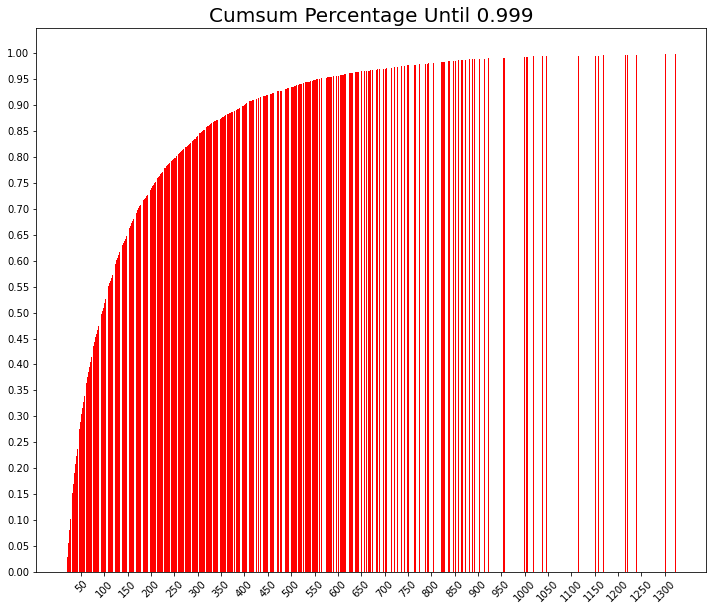

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
plt.bar(x=length_percent_cumsum_999.index,
        height=length_percent_cumsum_999, color='red')
# plt.xticks(length_percent_cumsum_999.index)
plt.xticks(np.arange(50,1350, 50))
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.xticks(rotation=45)
plt.show()

In [13]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [14]:
type(latest)

numpy.int64

In [15]:
#86400*30 최근 한달 자료 2592000

     
data_30 = data[data['Time'] > 1046454590-2592000]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data_30

,UserId,ItemId,Rating,Time
28225,195,2808,3,1044220118
27759,195,1254,4,1044552222
27921,195,1456,2,1044662852
28443,195,468,3,1044985356
28255,195,2748,1,1044987808
...,...,...,...,...
984731,5950,3948,4,1046369637
984682,5950,3578,4,1046369670
984475,5950,3793,3,1046369710
984660,5950,3555,2,1046369737


In [16]:
# 너무 적음 최근1년 자료 86400*365

data_365 = data[data['Time'] > 1046454590-31536000]   # 방금 구한 날짜 이후의 데이터만 모은다. 
data_365

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [17]:
# short_UserId을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('UserId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['UserId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [18]:
data_365_c = cleanse_recursive(data_365, shortest=2, least_click=5)
data_365_c

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [19]:
# 별점 기준 3 이상인것만 추천하도록하기위해 Rating 분포 확인
data_365_c['Rating'].value_counts()

4    6727
3    5168
5    3460
2    2224
1    1044
Name: Rating, dtype: int64

In [21]:
data_365_c_R = data_365_c[data_365_c['Rating']>=3]
data_365_c_R['Rating'].unique()

array([5, 4, 3], dtype=int32)

In [28]:
data_365_c_R

,UserId,ItemId,Rating,Time
5170,36,1387,5,1015904819
5267,36,1201,4,1015904819
5122,36,1291,5,1015904836
5123,36,2167,5,1015904905
5290,36,2951,4,1015904905
...,...,...,...,...
992358,5996,3835,3,1020113184
992279,5996,2422,3,1020113225
992702,5996,168,3,1031058746
992459,5996,339,4,1033997079


In [36]:
# dataset이 time column 을 따로 가지고 있어 타임라인을기준으로 나눈후 userId 별로세션을 설정
def split_by_date(data: pd.DataFrame, n_seconds: int):
    final_time = data['Time'].max()
    time_in_train = data[data['Time'] < final_time - n_seconds]
    time_in_test = data[data['Time'] >= final_time - n_seconds]

    return time_in_train, time_in_test

In [116]:
tr, test = split_by_date(data_365_c_R, 84600*7*8) #8주 초로 되어있음 int
tr, val = split_by_date(tr, 84600*7*16) # 16주

In [44]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t Users: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [45]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 9512
	 Users: 390
	 Items: 1504
	 First Time : 1014923199
	 Last Time : 1032228292

* valid Set Stats Info
	 Events: 3708
	 Users: 255
	 Items: 1250
	 First Time : 1032267965
	 Last Time : 1041714932

* test Set Stats Info
	 Events: 2135
	 Users: 157
	 Items: 1012
	 First Time : 1041723782
	 Last Time : 1046454590



In [119]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [47]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [61]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(50)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


In [85]:
tr_dataset.click_offsets

array([   0,   17,   21,   29,   34,   35,   71,   73,   79,   96,  105,
        116,  161,  171,  182,  201,  251,  269,  302,  304,  306,  326,
        331,  333,  336,  383,  435,  436,  439,  470,  473,  849,  854,
        873,  921,  926,  933,  943,  950,  987,  989, 1035, 1101, 1107,
       1132, 1136, 1244, 1250, 1251, 1256, 1349, 1351, 1390, 1391, 1397,
       1398, 1399, 1412, 1431, 1434, 1462, 1485, 1496, 1499, 1500, 1518,
       1524, 1525, 1534, 1667, 1708, 1721, 1725, 1821, 1853, 1861, 1868,
       1874, 1988, 1995, 2002, 2007, 2016, 2029, 2033, 2073, 2074, 2097,
       2100, 2106, 2112, 2142, 2150, 2153, 2190, 2197, 2269, 2294, 2297,
       2308, 2329, 2354, 2358, 2451, 2503, 2529, 2560, 2567, 2660, 2663,
       2702, 2770, 2772, 2776, 2782, 2791, 2801, 2857, 2893, 2898, 2906,
       2914, 2923, 3037, 3092, 3114, 3125, 3236, 3274, 3384, 3400, 3407,
       3418, 3472, 3488, 3587, 3636, 3717, 3800, 3834, 3844, 3848, 3879,
       3880, 3921, 3965, 3993, 4018, 4053, 4069, 40

In [86]:
tr_dataset.session_idx

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [49]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [89]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=2)
tr_dataset.df.head(15)

,UserId,ItemId,Rating,Time,item_idx
5170,36,1387,5,1015904819,0
5267,36,1201,4,1015904819,1
5122,36,1291,5,1015904836,2
5123,36,2167,5,1015904905,3
5290,36,2951,4,1015904905,4
5359,36,2115,5,1015904905,5
5073,36,1912,5,1015904924,6
5113,36,2662,3,1015904924,7
5366,36,2985,4,1015904941,8
5145,36,198,5,1015904988,9


In [90]:
iter_ex = iter(tr_data_loader)

In [91]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0 17]
Label Item Idx are :       [ 1 18]
Previous Masked Input Idx are []


In [92]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [93]:
# Model architecture

import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [94]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [103]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [104]:
model = create_model(args)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(50, 1, 1504)]           0         
_________________________________________________________________
GRU (GRU)                    [(50, 50), (50, 50)]      233400    
_________________________________________________________________
dropout_5 (Dropout)          (50, 50)                  0         
_________________________________________________________________
dense_5 (Dense)              (50, 1504)                76704     
Total params: 310,104
Trainable params: 310,104
Non-trainable params: 0
_________________________________________________________________


In [105]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [106]:
train_model(model, args)

Evaluation:  57%|█████▋    | 39/69 [00:10<00:07,  3.89it/s]


	 - Recall@20 epoch 1: 0.046154
	 - MRR@20    epoch 1: 0.007793



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.10it/s]


	 - Recall@20 epoch 2: 0.043077
	 - MRR@20    epoch 2: 0.007572



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.06it/s]


	 - Recall@20 epoch 3: 0.042051
	 - MRR@20    epoch 3: 0.007920



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.07it/s]


	 - Recall@20 epoch 4: 0.044615
	 - MRR@20    epoch 4: 0.008364



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.09it/s]


	 - Recall@20 epoch 5: 0.045641
	 - MRR@20    epoch 5: 0.007698



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.06it/s]


	 - Recall@20 epoch 6: 0.046154
	 - MRR@20    epoch 6: 0.009197



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.05it/s]


	 - Recall@20 epoch 7: 0.042564
	 - MRR@20    epoch 7: 0.009139



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.05it/s]


	 - Recall@20 epoch 8: 0.046667
	 - MRR@20    epoch 8: 0.009104



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.03it/s]


	 - Recall@20 epoch 9: 0.047179
	 - MRR@20    epoch 9: 0.009064



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.08it/s]


	 - Recall@20 epoch 10: 0.045128
	 - MRR@20    epoch 10: 0.008221



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.02it/s]


	 - Recall@20 epoch 11: 0.045641
	 - MRR@20    epoch 11: 0.010057



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.08it/s]


	 - Recall@20 epoch 12: 0.044103
	 - MRR@20    epoch 12: 0.010970



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.06it/s]


	 - Recall@20 epoch 13: 0.045128
	 - MRR@20    epoch 13: 0.012254



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.03it/s]


	 - Recall@20 epoch 14: 0.044615
	 - MRR@20    epoch 14: 0.012307



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.04it/s]


	 - Recall@20 epoch 15: 0.042564
	 - MRR@20    epoch 15: 0.012273



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.04it/s]


	 - Recall@20 epoch 16: 0.042051
	 - MRR@20    epoch 16: 0.013124



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.00it/s]


	 - Recall@20 epoch 17: 0.046667
	 - MRR@20    epoch 17: 0.013993



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.03it/s]


	 - Recall@20 epoch 18: 0.047179
	 - MRR@20    epoch 18: 0.014773



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.05it/s]


	 - Recall@20 epoch 19: 0.047179
	 - MRR@20    epoch 19: 0.015358



Evaluation:  57%|█████▋    | 39/69 [00:09<00:07,  4.10it/s]

	 - Recall@20 epoch 20: 0.047179
	 - MRR@20    epoch 20: 0.015610



In [109]:
# 1. Recall 및 MRR 값이 매우 안좋다 하이퍼 파라미터 변경
args = Args(tr, val, test, batch_size=50, hsz=100, drop_rate=0.2, lr=0.01, epochs=10, k=10)
train_model(model, args)

Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.35it/s]


	 - Recall@10 epoch 1: 0.027179
	 - MRR@10    epoch 1: 0.014231



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.44it/s]


	 - Recall@10 epoch 2: 0.027692
	 - MRR@10    epoch 2: 0.014347



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.37it/s]


	 - Recall@10 epoch 3: 0.028718
	 - MRR@10    epoch 3: 0.014229



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.44it/s]


	 - Recall@10 epoch 4: 0.030256
	 - MRR@10    epoch 4: 0.014082



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.40it/s]


	 - Recall@10 epoch 5: 0.030256
	 - MRR@10    epoch 5: 0.013638



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.26it/s]


	 - Recall@10 epoch 6: 0.031795
	 - MRR@10    epoch 6: 0.014417



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.21it/s]


	 - Recall@10 epoch 7: 0.032308
	 - MRR@10    epoch 7: 0.014155



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.25it/s]


	 - Recall@10 epoch 8: 0.032821
	 - MRR@10    epoch 8: 0.014309



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.48it/s]


	 - Recall@10 epoch 9: 0.032308
	 - MRR@10    epoch 9: 0.014157



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.01it/s]

	 - Recall@10 epoch 10: 0.032821
	 - MRR@10    epoch 10: 0.014242



- 리콜과 Mrr 값이 학습을 진행할수록 좋아지는 것은 확인하였으나 하이퍼 파라미터를 변경하여 보아도 값자체가 너무 않좋다.

In [117]:
#2.  모델 옵티마이저를 나담으로 변경
from tensorflow.keras.optimizers import Nadam

def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Nadam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [120]:
args = Args(tr, val, test, batch_size=50, hsz=100, drop_rate=0.2, lr=0.01, epochs=10, k=10)
train_model(model, args)

Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.30it/s]


	 - Recall@10 epoch 1: 0.032821
	 - MRR@10    epoch 1: 0.014206



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.37it/s]


	 - Recall@10 epoch 2: 0.032821
	 - MRR@10    epoch 2: 0.014513



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.37it/s]


	 - Recall@10 epoch 3: 0.031795
	 - MRR@10    epoch 3: 0.014391



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.35it/s]


	 - Recall@10 epoch 4: 0.031282
	 - MRR@10    epoch 4: 0.014420



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.30it/s]


	 - Recall@10 epoch 5: 0.031795
	 - MRR@10    epoch 5: 0.014599



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.33it/s]


	 - Recall@10 epoch 6: 0.031795
	 - MRR@10    epoch 6: 0.014695



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.39it/s]


	 - Recall@10 epoch 7: 0.032308
	 - MRR@10    epoch 7: 0.014906



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.37it/s]


	 - Recall@10 epoch 8: 0.031795
	 - MRR@10    epoch 8: 0.014717



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.29it/s]


	 - Recall@10 epoch 9: 0.029744
	 - MRR@10    epoch 9: 0.014670



Evaluation:  57%|█████▋    | 39/69 [00:06<00:04,  6.36it/s]

	 - Recall@10 epoch 10: 0.031795
	 - MRR@10    epoch 10: 0.014693



In [121]:
#3. K 값을 25로 변경 hsz 불필요하게 많은것 같아 줄임 드랍아웃 비율도 줄임
args = Args(tr, val, test, batch_size=50, hsz=50, drop_rate=0.05, lr=0.01, epochs=5, k=25)
train_model(model, args)

Evaluation:  57%|█████▋    | 39/69 [00:11<00:08,  3.39it/s]


	 - Recall@25 epoch 1: 0.055897
	 - MRR@25    epoch 1: 0.016037



Evaluation:  57%|█████▋    | 39/69 [00:11<00:08,  3.41it/s]


	 - Recall@25 epoch 2: 0.054872
	 - MRR@25    epoch 2: 0.016228



Evaluation:  57%|█████▋    | 39/69 [00:11<00:08,  3.42it/s]


	 - Recall@25 epoch 3: 0.054872
	 - MRR@25    epoch 3: 0.016223



Evaluation:  57%|█████▋    | 39/69 [00:11<00:08,  3.42it/s]


	 - Recall@25 epoch 4: 0.053846
	 - MRR@25    epoch 4: 0.016157



Evaluation:  57%|█████▋    | 39/69 [00:11<00:08,  3.43it/s]

	 - Recall@25 epoch 5: 0.054359
	 - MRR@25    epoch 5: 0.015998



## 회고 
- 추천시스템의 Session-Parallel Mini-Batches 시스템을 이용하여 병렬적으로 빠르게 연산을 수행시키는 방법을 적용시켜보았다. 
- 하이퍼파라미터 변경등을 통하여 Recall@25, MRR@25, accuracy, loss 등이 epoch 이 진행됨에 따라 개선 및 감소를 확인 하였다.  
- 추천시스템의 데이터 학습 세션수가 적어서(390 개) 모델이 학습하고 예측하기에 불충분한 것으로 생각된다.
- 영화의 경우 연도별로 다수의 최신작이 나오고 몇몇 영화를 제외하고는 유행을 타고 지나가기 때문에 학습에 사용할 데이터의 기간을 무한정 늘릴수가 없다고 알려져있다. 그리하여 총 데이터 중 1년치 데이터를 가지고 추천모델을 학습하여 보았는데 본 데이터셋의 경우에는 세션이 390개로 적어 전체데이터를 가지고 모델을 학습시키고 예측해볼 필요가 있다.